## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
#Libraries
import math
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageChops
from shapely import geometry
# import simple_lane_lines
%matplotlib qt 


In [2]:
# Computing the camera calibration matrix and distortion coefficients given a set of chessboard images.
def compute_calibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    nx = 9 # the number of inside corners in x
    ny = 6 # the number of inside corners in y
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/*.jpg')
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            # cv2.imshow('img',img)
            # cv2.waitKey(100)
    cv2.destroyAllWindows()
    return objpoints, imgpoints


# Applying distortion correction to raw images
def distortion_correction(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None, None)
    undist_img = cv2.undistort(img,  mtx, dist, None, mtx)    
    return undist_img


# Perspective transform
def perspective_transform(img, src_vertices, dst_vertices, img_size):
    transform_mat = cv2.getPerspectiveTransform(src_vertices, dst_vertices)
    inv_transform_mat = cv2.getPerspectiveTransform(dst_vertices, src_vertices)
    warped = cv2.warpPerspective(img, transform_mat, img_size, flags=cv2.INTER_LINEAR)
    return inv_transform_mat, warped


# x and y sobel Gradients
def mag_gradient(img,sobel_kernel,mag_thresh=(0,255)):
    #convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x gradiants
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # Sobel y gradiants
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        #Calculate the gradient magnitude
    grad_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    # grad_mag = np.sqrt(sobel_x**2)
    # Rescale to 8 bit
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(grad_mag)
    binary_output[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# S-channel thresholding
def hls_threshold(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_s_output = np.zeros_like(s_channel)
    binary_s_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

    return binary_s_output

# Histogram
def image_histogram(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)

    return histogram

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Finding lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fitting a second order polynomial to both lanes using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ## Visualization ##
    # Colors in the left(Red) and right(Blue) lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    return ploty, left_fit, right_fit, out_img

def plot_lanes(binary_warped, ploty, left_fit, right_fit):
    # Generate x and y values for plotting
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, binary_warped

def draw_curves(image_len, left_fitx, right_fitx, ploty, lane_color):
    lane_img = np.zeros((image_len[0], image_len[1], 3), dtype=np.uint8)

    left_curve = np.transpose(np.vstack([left_fitx, ploty]))
    cv2.polylines(lane_img,np.int_([left_curve]),False,lane_color,thickness=32)

    right_curve = np.transpose(np.vstack([right_fitx, ploty]))
    cv2.polylines(lane_img,np.int_([right_curve]),False,lane_color,thickness=32)

    pts = np.hstack((np.array([left_curve]), np.array([np.flipud(right_curve)])))
    cv2.fillPoly(lane_img, np.int_([pts]), (255,255, 0))

    return lane_img

def weighted_img(img, initial_img, α=0.3, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)


def measure_curvature_pixels(img_len_x, ploty, fitx):
    ym_p = 30/720 # meters per pixel in y dimension
    xm_p = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty) * ym_p
    camera_pos = (img_len_x/2) * xm_p

    A = fitx[0]*xm_p/(ym_p**2)
    B = fitx[1]*(xm_p/ym_p)
    C = fitx[2]*xm_p

    radius_of_curvature = ((1 + (2*A*y_eval +B)**2)**1.5) / np.absolute(2*A)

    dist_center = A*y_eval**2+B*y_eval+C-camera_pos
    return radius_of_curvature, dist_center

def add_text_to_image(image, box_pos, radius_of_curvature, dist_center, text_pos):
    image = cv2.rectangle(image, box_pos[0], box_pos[1], (250,218,94), -1) 
    txt_roc = "Radius of Curvature: " + str(round(radius_of_curvature,2)) + " m"
    txt_center_pos = "Position: " + str(round(dist_center,2)) + " m"
    cv2.putText(image,txt_roc,text_pos[0], cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 2)
    cv2.putText(image,txt_center_pos,text_pos[1], cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 2)

    return image


In [3]:
def pipeline(img):

    src_points = [[260,655],[580,458],[710,458],[1040,655]]  
    src_vertices = np.float32([src_points])

    dst_points = [[260,655],[270,0],[1030,0],[1040,655]]
    dst_vertices = np.float32([dst_points])
        
    img_size = (img.shape[1], img.shape[0])

    # apply the calibration data to test images
    undist_img =distortion_correction(img, obj_points, img_points)
    #cv2.imwrite( "./output_images/Lane_Image.jpg", undist_img)


    # sobel_x gradient
    mag_binary = mag_gradient(undist_img, 3, mag_thresh = (50,100))
    # HLS color space, S-channel thresholding
    binary_s_output= hls_threshold(undist_img, (160,190))
# (165,190)

    # stacked images for visualization
    color_binary = np.dstack(( np.zeros_like(mag_binary), mag_binary, binary_s_output)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(mag_binary)
    combined_binary[(binary_s_output == 1) | (mag_binary == 1)] = 255

    # Applying Perspective transform
    inv_perspective_mat, warped = perspective_transform(combined_binary, src_vertices, dst_vertices, img_size)

    ploty, left_fit, right_fit, windowed_img = fit_polynomial(warped)
    left_fitx, right_fitx, lanes_image= plot_lanes(windowed_img, ploty, left_fit, right_fit)

    lane_image = draw_curves(windowed_img.shape, left_fitx, right_fitx, ploty, lane_color = (255,0 ,0))

    left_curverad, dist_center_left = measure_curvature_pixels(img_size[0], ploty, left_fit)
    right_curverad, dist_center_right = measure_curvature_pixels(img_size[0], ploty, right_fit)
    # print(fname.replace('./test_images', ''), left_curverad, right_curverad)

    unwarped = cv2.warpPerspective(lane_image, inv_perspective_mat, img_size, flags=cv2.INTER_LINEAR)
    image_with_lanes = weighted_img(undist_img, unwarped)

    xm_p = 3.7/700 # meters per pixel in x dimension
    camera_pos = (img_size[0]/2)
    deviation = (((left_fitx[-1] + right_fitx[-1])/2)-camera_pos) * xm_p

    image_with_lanes = cv2.rectangle(image_with_lanes, (515,24), (770,61), (250,218,94), -1) 
    txt_roc = "Deviation: " + str(round(deviation,2)) + " m"
    cv2.putText(image_with_lanes,txt_roc,(520 , 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 2)

    image_with_lanes = add_text_to_image(image_with_lanes,((5,5),(435,80)), left_curverad, dist_center_left, ((10, 30),(10,60)))
    image_with_lanes = add_text_to_image(image_with_lanes,((850,5),(1280,80)), right_curverad, dist_center_right, ((855, 30),(855,60)))

    return image_with_lanes,mag_binary,binary_s_output, warped, lanes_image

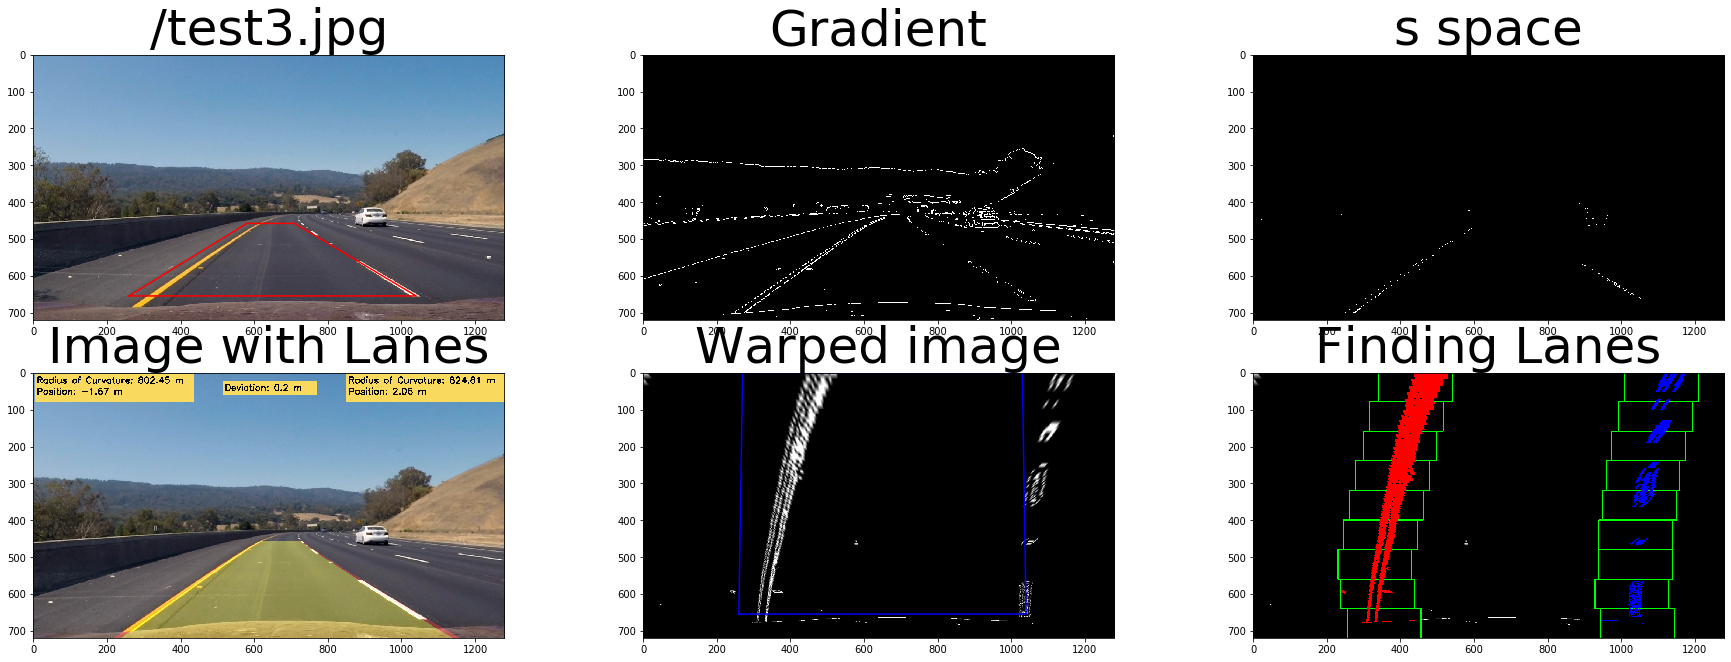

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [4]:
### Testing pipeline on images

# compute calibration data.
obj_points, img_points = compute_calibration()

images = glob.glob('./test_images/*.jpg')

thresh=(90, 255)

f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 9))

src_points = [[260,655],[580,458],[710,458],[1040,655]]
src_vertices = np.float32([src_points])
poly_src = geometry.Polygon(src_points)
src_x,src_y = poly_src.exterior.xy

# dst_points = [[280,655],[280,0],[1020,0],[1020,655]]
dst_points = [[260,655],[270,0],[1030,0],[1040,655]]
dst_vertices = np.float32([dst_points])
poly_dst = geometry.Polygon(dst_points)
dst_x,dst_y = poly_dst.exterior.xy


for fname in images:
    img = mpimg.imread(fname) #RGB image

    image_with_lanes,mag_binary,binary_s_output, warped, lanes_image = pipeline(img)


    histogram = image_histogram(warped)
    # Plot
    ax1.imshow(img)
    ax1.plot(src_x,src_y, 'r')
    ax1.set_title(fname.replace('./test_images', ''), fontsize=50)
    
    ax2.imshow(mag_binary, cmap='gray')
    ax2.set_title('Gradient', fontsize=50)
    
    ax3.imshow(binary_s_output, cmap='gray')
    ax3.set_title('s space', fontsize=50)
    
    ax4.imshow(image_with_lanes)
    ax4.set_title('Image with Lanes', fontsize=50)
    
    ax5.plot(dst_x,dst_y, 'b')
    ax5.imshow(warped, cmap='gray')
    ax5.set_title('Warped image', fontsize=50)
    
    ax6.imshow(lanes_image)
    ax6.set_title('Finding Lanes', fontsize=50)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    plt.pause(1)
    fig_name = "./output_images/" + fname.replace('./test_images/', 'fig_')
    f.savefig(fig_name)

    # Saving the images
    name = "./output_images" + fname.replace('./test_images', '')
    pil_img = Image.fromarray(image_with_lanes)
    pil_img.save(name)

plt.close('all')




In [5]:
def video_pipeline(img):
    image_with_lanes,mag_binary,binary_s_output, warped, lanes_image = pipeline(img)

    # warped_rgb = cv2.cvtColor(warped,cv2.COLOR_GRAY2RGB)
    # h_stacked_im = np.hstack((warped_rgb, lanes_image))

    # scale_percent = 50 # percent of original size
    # width = int(h_stacked_im.shape[1] * scale_percent / 100)
    # height = int(h_stacked_im.shape[0] * scale_percent / 100)
    # dim = (width, height)
    # # resize image
    # resized = cv2.resize(h_stacked_im, dim, interpolation = cv2.INTER_AREA)

    # v_stacked_im = np.vstack((resized, image_with_lanes))

    return image_with_lanes


In [6]:
###Testing piepline on video

from moviepy.editor import VideoFileClip
from IPython.display import HTML

obj_points, img_points = compute_calibration()
video_out = './output_images/project_video_out.mp4'
video_in = VideoFileClip("project_video.mp4").subclip(41,43)

clip = video_in.fl_image(video_pipeline)

%time clip.write_videofile(video_out, audio=False)

t:   0%|          | 0/50 [00:00<?, ?it/s, now=None]Moviepy - Building video ./output_images/project_video_out.mp4.
Moviepy - Writing video ./output_images/project_video_out.mp4

t: 100%|██████████| 50/50 [00:41<00:00,  1.19it/s, now=None]Moviepy - Done !
Moviepy - video ready ./output_images/project_video_out.mp4
CPU times: user 1min 47s, sys: 1.96 s, total: 1min 49s
Wall time: 42.7 s
